In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import numpy as np
%matplotlib inline
torch.manual_seed(42)

In [ ]:
import os
import pandas as pd

In [ ]:
print(f"CUDA is available? {torch.cuda.is_available()}")
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

CUDA is available? False
cpu


In [ ]:
# Define root directory from Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal



In [ ]:
dataset_path = './dataset'
covid_dataset_path = '/content/drive/My Drive/covid-chestxray-dataset-master/'

In [ ]:
meta_data = pd.read_csv(covid_dataset_path+'metadata.csv',index_col=[0])
meta_data.head(10)

,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
patientid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,3.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,5.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,6.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,0.0,F,52.0,COVID-19,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
4,5.0,F,52.0,COVID-19,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
5,NaN,NaN,NaN,ARDS,NaN,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN,NaN
6,0.0,NaN,NaN,COVID-19,NaN,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
6,4.0,NaN,NaN,COVID-19,NaN,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN


In [ ]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [ ]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] == "COVID-19":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [ ]:
%%bash
pip install split-folders
pip install split-folders tqdm

In [ ]:
%%bash
rm -rf split_dataset
mkdir -p split_dataset

In [ ]:
import split_folders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('/content/dataset', output="/content/split_dataset", seed=1337, ratio=(.6, .2, .2)) # default values

Copying files: 647 files [00:01, 519.63 files/s]


In [ ]:
"""
# Images are cropped to 225 x 225
# We consider a simple 3x3 jigsaw puzzle.
#Senza spazi
#perm_inds = [(0,0),(75,0),(150,0),(150,75),(75,75),(0,75),(150,150),(75,150),(0,150)]
#
perm_inds = [(11,11),(86,11),(161,11),(161,86),(86,86),(11,86),(161,161),(86,161),(11,161)] #così croppo i tile 75x75 a 64x64
perm_inds1 = [(0,0),(64,0),(128,0),(128,64),(64,64),(0,64),(128,128),(64,128),(0,128)]
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute3x3(images):
   
    p1_images = torch.FloatTensor(images.size()[0],3,192,192)
    perms = torch.LongTensor(images.size()[0], 9)
    for i in range(images.size()[0]):
        p = torch.randperm(9)
        for j in range(9):
            sr, sc = perm_inds[j]
            tr1, tc1 = perm_inds1[p[j]]
            tr, tc = perm_inds[p[j]]
            p1_images[i, :, tr1:tr1+64, tc1:tc1+64] = images[i, :, sr:sr+64, sc:sc+64]  
        perms[i,:] = p  
    return(p1_images, perms)


def restore3x3(p_images, perms):
   
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(9):
            sr, sc = perm_inds1[j]
            tr, tc = perm_inds1[perms[i, j]]
            images[i, :, sr:sr+64, sc:sc+64] = p_images[i, :, tr:tr+64, tc:tc+64]
    return images

def perm2vecmat3x3(perms):
  
    n = perms.size()[0]
    mat = torch.zeros(n, 9, 9)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(9):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def vecmat2perm3x3(x):

    n = x.size()[0]
    x = x.view(n, 9, 9)
    _, ind = x.max(2)
    return ind
    
def imshow(img, title=None):
  
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)
"""

'\n# Images are cropped to 225 x 225\n# We consider a simple 3x3 jigsaw puzzle.\n#Senza spazi\n#perm_inds = [(0,0),(75,0),(150,0),(150,75),(75,75),(0,75),(150,150),(75,150),(0,150)]\n#\nperm_inds = [(11,11),(86,11),(161,11),(161,86),(86,86),(11,86),(161,161),(86,161),(11,161)] #così croppo i tile 75x75 a 64x64\nperm_inds1 = [(0,0),(64,0),(128,0),(128,64),(64,64),(0,64),(128,128),(64,128),(0,128)]\n# Simply maps each pixel to [-1, 1]\nimg_mean = 0.5\nimg_std = 0.5\n    \ndef permute3x3(images):\n   \n    p1_images = torch.FloatTensor(images.size()[0],3,192,192)\n    perms = torch.LongTensor(images.size()[0], 9)\n    for i in range(images.size()[0]):\n        p = torch.randperm(9)\n        for j in range(9):\n            sr, sc = perm_inds[j]\n            tr1, tc1 = perm_inds1[p[j]]\n            tr, tc = perm_inds[p[j]]\n            p1_images[i, :, tr1:tr1+64, tc1:tc1+64] = images[i, :, sr:sr+64, sc:sc+64]  \n        perms[i,:] = p  \n    return(p1_images, perms)\n\n\ndef restore3x3(p_im

***3 x 3***

In [ ]:
# Images are cropped to 225 x 225
# We consider a simple 3x3 jigsaw puzzle.
# 0 1 2
# 5 4 3
# 8 7 6
perm_inds = [(0,0),(75,0),(150,0),(150,75),(75,75),(0,75),(150,150),(75,150),(0,150)]
#
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5

rc = transforms.transforms.RandomCrop([64, 64])
rz = transforms.transforms.Resize([75, 75])
toPIL = transforms.transforms.ToPILImage()
toTensor = transforms.transforms.ToTensor()
    
def permute3x3(images):
    """
    Splits the images into 3x3 = 9 pieces and randomly permutes the pieces.
    """
    #print("permute3x3")
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 9)
    tmp = torch.LongTensor(3,75,75)
    for i in range(images.size()[0]):
        p = torch.randperm(9)
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            temp = images[i, :, sr:sr+75, sc:sc+75]
            out = toTensor(rz(rc(toPIL(temp))))
            p_images[i, :, tr:tr+75, tc:tc+75] = out
        perms[i,:] = p
    return(p_images, perms)

def restore3x3(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+75, sc:sc+75] = p_images[i, :, tr:tr+75, tc:tc+75]
    return images

def perm2vecmat3x3(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    tensor([4, 3, 0, 7, 6, 2, 8, 5, 1])
  tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.]])
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 9, 9)
    for i in range(n):
        for k in range(9):
            mat[i, k, perms[i, k]] = 1.
    riga = mat.view(n, -1)
    #print("perm2vecmat3x3")
    #print("Permutazione in matrice -> ingresso:",perms,perms.size())
    #print("Permutazione in riga -> uscita:",riga[0],riga.size())
    return mat.view(n, -1)

def vecmat2perm3x3(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.]])
        tensor([5, 7, 8, 1, 2, 0, 6, 3, 4])
        torch.Size([B, 81])
    """
    n = x.size()[0]
    x = x.view(n, 9, 9)
    _, ind = x.max(2)
    #print("vecmat2perm3x3")
    #print("Permutazione in matrice -> ingresso:",x,x.size())
    #print("Permutazione in riga -> uscita:",ind,ind.size())
    return ind
    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

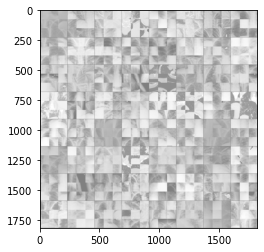

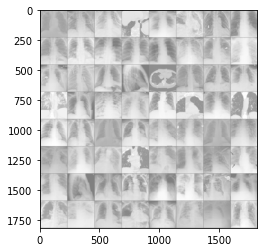

In [ ]:
batch_size = 64
dataset_dir = '/content/split_dataset/'

transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(225),
     transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor()])

test_set = torchvision.datasets.ImageFolder(root = dataset_dir+'test' ,transform=transform)
train_set = torchvision.datasets.ImageFolder(root = dataset_dir+'train' ,transform=transform)
val_set = torchvision.datasets.ImageFolder(root = dataset_dir+'val' ,transform=transform)
# Plot as example the train_set.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=0)
dataiter = iter(train_loader)
images, labels = next(dataiter)

p_images , perms = permute3x3(images)

# Check the implementation of per2vecmat and vecmat2perm.
assert(vecmat2perm3x3(perm2vecmat3x3(perms)).equal(perms))

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore3x3(p_images, perms)))

***FINE 3x3 ***

In [ ]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=0)
print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(val_loader)))
print('Number of test batches: {}'.format(len(test_loader)))

Number of training batches: 13
Number of validation batches: 5
Number of test batches: 5


In [ ]:
# Imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Define class
class JigsawConv(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.conv_layers1 = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers2 = nn.Sequential(
             # Layer 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers3 = nn.Sequential(
            # Layer 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers4 = nn.Sequential(
             # Layer 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(),
            nn.BatchNorm2d(384),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers5 = nn.Sequential(
             # Layer 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),    
        )
        self.fc6_layers = nn.Sequential(
          # FC layer fc6
          nn.Linear(256*3*3, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
        )
    # Forward
    def forward(self, x):
        #print("Input: ",x.size())
        x = self.conv_layers1(x)
        #print("Layer 1: " , x.size())
        x = self.conv_layers2(x)
        #print("Layer 2: " , x.size())
        x = self.conv_layers3(x)
        #print("Layer 3: " , x.size())
        x = self.conv_layers4(x)
        #print("Layer 4: " , x.size())
        x = self.conv_layers5(x)
        #print("Layer 5: ", x.size())
        x = x.view(x.size(0), -1)
        #print("Transfor in view per il layer 6: ",x.size())
        x = self.fc6_layers(x)
        #print("Layer 6: ",x.size())
        return x
# Define class
class JigsawFullyC(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.fc7_layers = nn.Sequential(
            # FC layer fc7
            nn.Linear(9*1024, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.fc8_layers = nn.Sequential(
            # FC layer fc7
            nn.Linear(4096, 81),
            nn.Sigmoid(),
        )
    # Forward
    def forward(self, x):
        #print("Input Fully Connected",x.size())
        x = self.fc7_layers(x)
        #print("Layer 7: ",x.size())
        x = self.fc8_layers(x)
        #print("Layer 8: ",x.size())
        return x

class JigsawNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_net = JigsawConv()
        self.fully_net = JigsawFullyC()
    
    def forward(self, x):
     
        x0 = self.conv_net(x[:, :, 0:75,150:225])
        x1 = self.conv_net(x[:, :, 0:75, 75:150])
        x2 = self.conv_net(x[:, :, 0:75, 0:75])
        x3 = self.conv_net(x[:, :, 75:150, 150:225])
        x4 = self.conv_net(x[:, :, 75:150, 75:150])
        x5 = self.conv_net(x[:, :, 75:150, 0:75])
        x7 = self.conv_net(x[:, :, 150:225, 75:150])    
        x6 = self.conv_net(x[:, :, 150:225, 150:225])
        x8 = self.conv_net(x[:, :, 150:225 ,0:75])
        # Cat
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7 , x8], dim=1)
        # Dense layer
        x = self.fully_net(x)
        #print("Uscita Jigsaw: ",x.size())
        return x

In [ ]:
 """
        x0 = self.conv_net(x[:, :, 0:75, 0:75])
        x1 = self.conv_net(x[:, :, 75:150, 0:75])
        x2 = self.conv_net(x[:, :, 150:225 ,0:75])
        x3 = self.conv_net(x[:, :, 150:225, 75:150])
        x4 = self.conv_net(x[:, :, 75:150, 75:150])
        x5 = self.conv_net(x[:, :, 0:75, 75:150])
        x6 = self.conv_net(x[:, :, 150:225, 150:225])
        x7 = self.conv_net(x[:, :, 75:150, 150:225])
        x8 = self.conv_net(x[:, :, 0:75,150:225])
     """  

'\n       x0 = self.conv_net(x[:, :, 0:75, 0:75])\n       x1 = self.conv_net(x[:, :, 75:150, 0:75])\n       x2 = self.conv_net(x[:, :, 150:225 ,0:75])\n       x3 = self.conv_net(x[:, :, 150:225, 75:150])\n       x4 = self.conv_net(x[:, :, 75:150, 75:150])\n       x5 = self.conv_net(x[:, :, 0:75, 75:150])\n       x6 = self.conv_net(x[:, :, 150:225, 150:225])\n       x7 = self.conv_net(x[:, :, 75:150, 150:225])\n       x8 = self.conv_net(x[:, :, 0:75,150:225])\n    '

In [ ]:
x = torch.Tensor([[3, 0, 2, 6, 2, 3, 3, 0, 4]])
print(x.size())
y = torch.Tensor([[3, 0, 2, 6, 2, 3, 3, 0, 4]])
print(y.size())
d = torch.sum(x == y,0)
print(d)

torch.Size([1, 9])
torch.Size([1, 9])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# Test helper
save_model_path = '/content/drive/My Drive/Checkpoint'
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    #print("p_pred",p_pred,p_pred.size())
    #print("p_true",p_true,p_true.size())
    #print(torch.sum(p_pred == p_true, 1))
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float())
    #print("Questa è n:",n)
    #print("p_pred",p_pred.size()[0])
    if average:
        n = n / p_pred.size()[0]
        return n
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, val_loader,
                n_epochs=1):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                x_in, perms = permute3x3(inputs)
                #print("x_in: ",x_in,x_in.size())
                #print("permutazione x_in: ",perms)
                y_in = perm2vecmat3x3(perms)
                #print("y_in: ",y_in,y_in.size())
                #print("permutazione y_in: ", perm2vecmat3x3(perms))
                n_samples += inputs.size()[0]
                #print("n_samples: ",n_samples)
                x_in, y_in = x_in.to(dev),y_in.to(dev)
                perms = perms.to(dev)
                optimizer.zero_grad()
                outputs = model(x_in)
                #print("output: ",outputs,outputs.size())
                n_correct_pred += compute_acc(vecmat2perm3x3(outputs), perms, False).data
                loss = criterion(outputs, y_in)
                #print("loss: ",loss)
                loss.backward()
                optimizer.step()
                running_loss += loss.data * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(val_loader, 0):
                inputs, _ = data
                x_in, perms = permute3x3(inputs)
                y_in = perm2vecmat3x3(perms)
                n_samples += inputs.size()[0]
                x_in, y_in = x_in.to(dev), y_in.to(dev)
                perms = perms.to(dev)
                outputs = model(x_in)
                #print("Ecco l'ouput size",outputs.size())
                n_correct_pred += compute_acc(vecmat2perm3x3(outputs), perms, False).data
                #print("Ecco quello corretto",n_correct_pred)
                loss = criterion(outputs, y_in)
                running_loss += loss.data * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    print("Ok sto salvando")
    torch.save(model, save_model_path)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute3x3(inputs)
        y_in = perm2vecmat3x3(perms)
        x_in, y_in = x_in.to(dev), y_in.to(dev)
        pred = model(x_in)
        perms_pred = vecmat2perm3x3(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [ ]:
# Create the neural network.
model = JigsawNet()
model.to(dev)
print(model)

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay = 5e-4)
  
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
history = train_model(model, criterion, optimizer, train_loader, val_loader)

Epoch 1:   0%|          | 0/7 [00:00<?, ?b/s]

JigsawNet(
  (conv_net): JigsawConv(
    (conv_layers1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_layers2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
      (1): ReLU()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_layers3): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_layers4): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2

Epoch 001: loss=0.6928, val_loss=0.5640, acc=0.00%, val_acc=0.00%
Training completed
Ok sto salvando


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type JigsawNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type JigsawConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type JigsawFullyC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, val_loader)))
print('Test accuracy: {}'.format(test_model(model, test_loader)))
# Here training accuracy will be higher because dropout is disabled

In [ ]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms = permute3x3(test_images)

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()

model.eval()
pred = model(p_images.to(dev))
perms_pred = vecmat2perm3x3(pred.to(dev).data)

# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore3x3(p_images, perms_pred)))
plt.title('Restored')
plt.show()

 Seconda Parte Fine Tuning tex

In [ ]:

model_tf = torch.load(save_model_path)
model_tf.fully_net=ClassificationLayer()




<bound method Module.state_dict of JigsawNet(
  (conv_net): JigsawConv(
    (conv_layers1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_layers2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
      (1): ReLU()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_layers3): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_layers4): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stri

In [ ]:
# Define class
class ClassificationLayer(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.fc7_layers = nn.Sequential(
            # FC layer fc7
            nn.Linear(1024, 2),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
    # Forward
    def forward(self, x):
        #print("Input Fully Connected",x.size())
        x = self.fc7_layers(x)
        #print("Layer 7: ",x.size())
        return x

In [ ]:
# Start training
# HINT:
# - change the number of epochs as you want
# - you can always interrupt training by clicking on the "interrupt kernel" on the toolbar
# - you can set a small number of epochs, train for a while, plot losses, and then train again
# - in general, training for at most 50 epochs will be ok
epoch = 50
for epoch in range(epoch):
  # Initialize variables for computing average loss/accuracy
  sum_loss = {"train": 0, "val": 0, "test": 0}
  sum_accuracy = {"train": 0, "val": 0, "test": 0}
  # Process each split
  for split in ["train", "val", "test"]:
      # Set network mode (train or eval)
      if split == 'train':
        model_tf.train()
        print ("mode trained actived, ", split)
      else:
        model_tf.eval()
        print ("mode evaluation  actived, ", split)  
      # Process all data in split
      for i,(input, labels) in enumerate(loaders[split]):
        # Read data
        # ...
        # Move to CUDA
        input = input.to(dev)
        labels = labels.to(dev)
        # Compute loss
        # Reset gradients
        optimizer.zero_grad()
        # Compute output
        pred = model_tf(input)
        loss = F.cross_entropy(pred, labels)
        # Update variables for average epoch loss
        sum_loss[split] += loss.item()
        # Backward and optimize
        if split == "train":
          # Compute gradients
          loss.backward()
          # Optimize
          optimizer.step()
        # Compute accuracy
        _,pred_labels = pred.max(1)
        batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
        # Update variables for average epoch accuracy
        sum_accuracy[split] += batch_accuracy
  # Compute average epoch loss/accuracy
  epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
  epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
  # Append average values to history lists
  for split in ["train", "val", "test"]:
    history_loss[split].append(epoch_loss[split])
    history_accuracy[split].append(epoch_accuracy[split])
  print(f"Epoch {epoch+1}:",
    f"TrL={epoch_loss['train']:.4f},",
    f"TrA={epoch_accuracy['train']:.4f},",
    f"VL={epoch_loss['val']:.4f},",
    f"VA={epoch_accuracy['val']:.4f},",
    f"TeL={epoch_loss['test']:.4f},",
    f"TeA={epoch_accuracy['test']:.4f},")
  # Check if we obtained the best validation accuracy
  if (epoch_accuracy['val'] > best_val_accuracy):
    # Update best validation accuracy and test accuracy at best validation
    best_val_accuracy =  epoch_accuracy['val'] 
    test_accuracy_at_best_val =  epoch_accuracy['test'] 